
Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Accessing CANSIM NDM vectors from Statistics Canada

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as

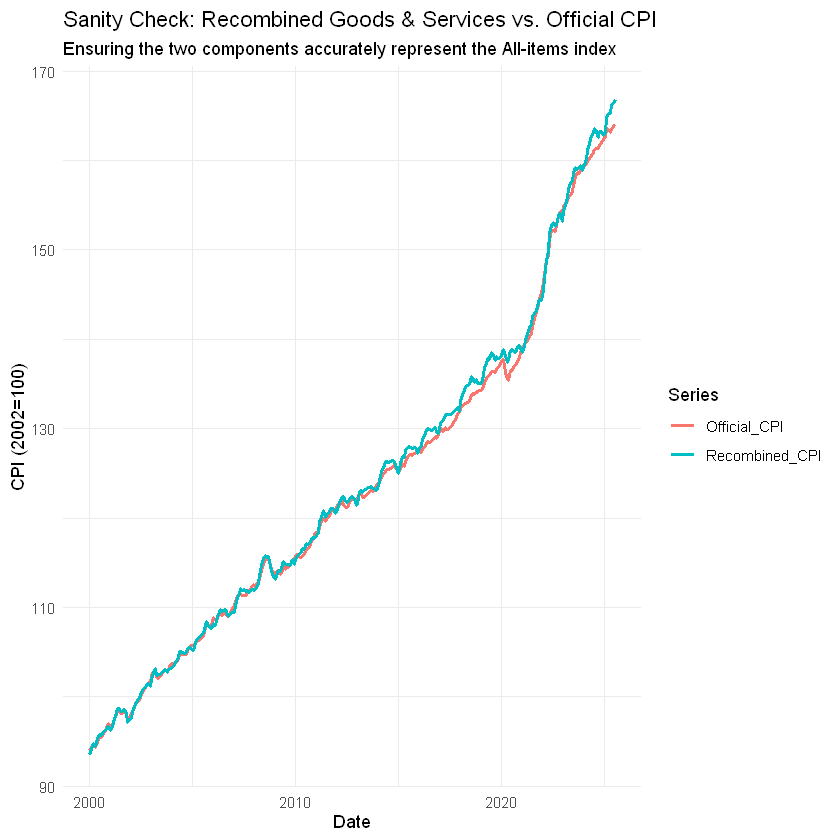

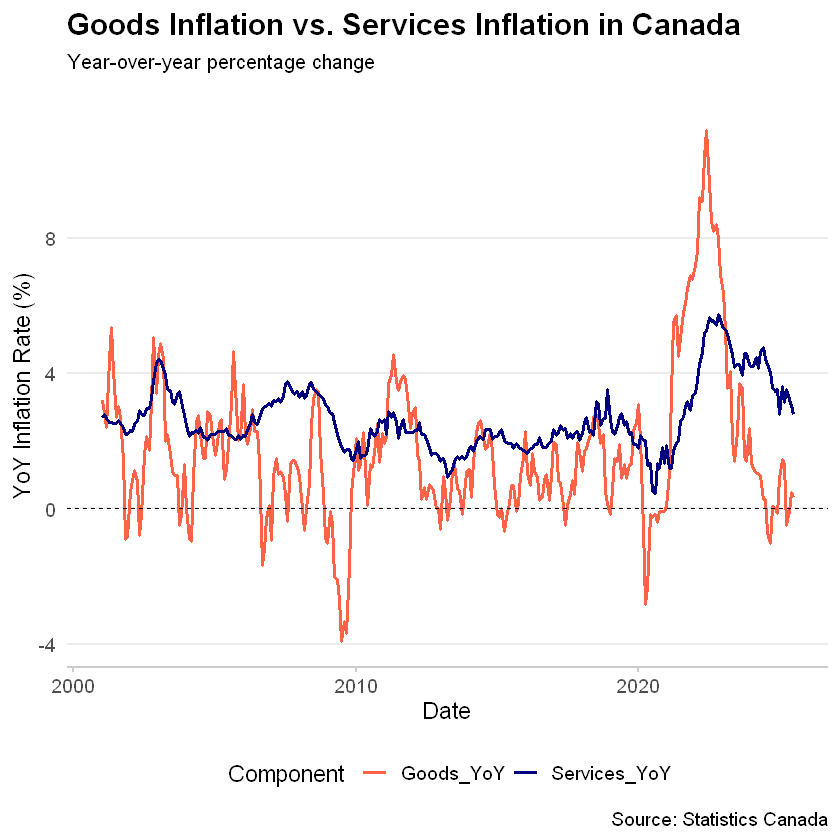

In [2]:
# --- 0. LOAD LIBRARIES ---
# Ensure all necessary packages are loaded
library(cansim)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)


# --- 1. DEFINE VECTORS FOR GOODS AND SERVICES ---

# Vectors for the CPI basket weights
cpi_weight_vectors <- c(
  Goods = "v91859278",
  Services = "v91873252"
)

# Vectors for the CPI index levels
cpi_vectors <- c(
  Goods = "v41691222",
  Services = "v41691230"
)


# --- 2. DOWNLOAD AND PROCESS DATA ---

# --- CPI Data (Monthly) ---
# Download and combine the monthly CPI data for Goods and Services
cpi_data_long <- purrr::map2_df(
  cpi_vectors,
  names(cpi_vectors),
  ~ get_cansim_vector(.x, start_time = "2000-01-01") %>% mutate(Component = .y)
)

# Convert to wide format for easy calculations
cpi_data_wide <- cpi_data_long %>%
  dplyr::select(Date, Component, VALUE) %>%
  pivot_wider(names_from = Component, values_from = VALUE) %>%
  arrange(Date)


# --- Weight Data (Annual/Biennial) ---
# Download and combine the weight data
weights_data_long <- purrr::map2_df(
  cpi_weight_vectors,
  names(cpi_weight_vectors),
  ~ get_cansim_vector(.x, start_time = "1996-01-01") %>% mutate(Component = .y)
)

# Process weights: create a complete monthly series, fill forward, and lag by 1 year
monthly_weights_df <- weights_data_long %>%
  dplyr::select(Date, Component, VALUE) %>%
  pivot_wider(names_from = Component, values_from = VALUE) %>%
  # Create a row for every month
  complete(Date = seq.Date(min(Date), today(), by = "month")) %>%
  # Fill the empty months with the last known weight
  fill(everything(), .direction = "down") %>%
  # Lag weights to align the basket measurement period with the CPI calculation period
  mutate(across(-Date, ~lag(.x, 12))) %>%
  # Remove any initial rows that are now NA
  filter(!is.na(Goods))


# --- 3. SANITY CHECK: RECOMBINE AND COMPARE TO TOTAL CPI ---

# Vector for the official "All-items CPI"
total_cpi_vector <- "v41690914"
official_cpi_df <- get_cansim_vector(total_cpi_vector, start_time = "2000-01-01") %>%
  dplyr::select(Date, Official_CPI = VALUE)

# Join CPI data with the prepared monthly weights
recombined_df <- cpi_data_wide %>%
  left_join(monthly_weights_df, by = "Date", suffix = c("_CPI", "_Weight")) %>%
  filter(!is.na(Goods_Weight)) %>%
  # Recombine using the weights
  mutate(
    Total_Weight = Goods_Weight + Services_Weight,
    Recombined_CPI = (Goods_CPI * Goods_Weight + Services_CPI * Services_Weight) / Total_Weight
  ) %>%
  # Join with the official CPI for comparison
  left_join(official_cpi_df, by = "Date")


# --- Plot the Sanity Check ---
# Tidy the data for plotting
sanity_check_plot_data <- recombined_df %>%
  dplyr::select(Date, Recombined_CPI, Official_CPI) %>%
  pivot_longer(cols = -Date, names_to = "Series", values_to = "Value")

# Generate the plot
sanity_check_plot <- ggplot(sanity_check_plot_data, aes(x = Date, y = Value, color = Series)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Sanity Check: Recombined Goods & Services vs. Official CPI",
    subtitle = "Ensuring the two components accurately represent the All-items index",
    y = "CPI (2002=100)",
    x = "Date"
  ) +
  theme_minimal()

# Display the sanity check plot
print(sanity_check_plot)


# --- 4. CALCULATE AND PLOT YOY INFLATION FOR GOODS VS. SERVICES ---

# Calculate the YoY % change directly from the wide CPI data
inflation_goods_services_df <- cpi_data_wide %>%
  mutate(
    Goods_YoY = ((Goods / lag(Goods, 12)) - 1) * 100,
    Services_YoY = ((Services / lag(Services, 12)) - 1) * 100
  ) %>%
  dplyr::select(Date, ends_with("_YoY")) %>%
  filter(!is.na(Goods_YoY))

# Tidy the data for the final plot
inflation_plot_data <- inflation_goods_services_df %>%
  pivot_longer(cols = -Date, names_to = "Component", values_to = "YoY_Change")


# --- Plot the Final Inflation Rates ---
final_plot <- ggplot(inflation_plot_data, aes(x = Date, y = YoY_Change, color = Component)) +
  geom_line(linewidth = 1) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = "Goods Inflation vs. Services Inflation in Canada",
    subtitle = "Year-over-year percentage change",
    y = "YoY Inflation Rate (%)",
    x = "Date",
    color = "Component",
    caption = "Source: Statistics Canada"
  ) +
  scale_color_manual(values = c("Goods_YoY" = "tomato", "Services_YoY" = "navy")) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "bottom"
  )

# Display the final plot
print(final_plot)

In [3]:
ggsave(
  "goods_v_services_inflation.png", # The filename for the saved plot
  plot = final_plot,                # The plot object to save
  width = 17,              # Width in inches
  height = 8,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [4]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.1.0     ✔ tibble  3.3.0
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo

In [5]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')

In [6]:
# --- Statistics Canada Data ---
cpi_vec <- get_cansim_vector_for_latest_periods("v108785715", periods = 500) # Monthly CPI, pct change
unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500) # Unemployment Rate
fcpi_vec <- get_cansim_vector_for_latest_periods('v52673496', periods = 500) # Fisher Commodity Price Index
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300) # Monthly GDP
monthly_conventional_bond <- get_cansim_vector_for_latest_periods('v122543', periods = 500) # Conventional Bond Yield
monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553', periods = 500) # Real Return Bond Yield
# --- Bank of Canada Policy Interest Rate ---
policy_rate_daily_vec <- get_cansim_vector("v39050", start_time = "2000-01-01")
ippi_vec <- get_cansim_vector_for_latest_periods("v1249303102", periods = 500)

# --- FRED Data ---
wti_price_monthly <- fredr(series_id = "MCOILWTICO", observation_start = as.Date("1990-01-01")) # WTI Oil Price
exc_rate <- fredr(series_id = "DEXCAUS", observation_start = as.Date("1990-01-01"), frequency = "m", units = "chg") # US-CAN Exchange Rate
trade_commodities <- fredr(series_id = "XTNTVA01CAM664S", observation_start = as.Date("1990-01-01"), frequency = "m", units = "chg") # Trade in Goods

# --- Local CSV Files ---
all_tariff_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")
tpu_data <- read_csv("Categorical_EPU_Data.csv")
supply_chain_pressure <- read_csv("C:/Users/Irene/governorschallenge/gscpi_data.csv")
lfs_micro <- read_csv('C:/Users/Irene/governorschallenge/INDINF_WAGES_MONTHLY.csv', skip = 20)
housing_prices <- read_csv("C:/Users/Irene/governorschallenge/House_Price_Index.csv")

Accessing CANSIM NDM vectors from Statistics Canada



Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Rows: 616 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
ch

In [7]:
glimpse(housing_prices)

Rows: 422
Columns: 61
$ Date                     <chr> "Jun-90", "Jul-90", "Aug-90", "Sep-90", "Oct-…
$ Index...2                <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ `SA Index...3`           <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Smoothed_Index           <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ `Smoothed SA Index...5`  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ `Sales Pair Count...6`   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Index...7                <dbl> 45.27, 46.46, 46.21, 45.89, 46.81, 44.88, 46.…
$ `SA Index...8`           <dbl> 45.17, 46.23, 45.96, 46.19, 46.95, 45.05, 45.…
$ `Smoothed Index...9`     <dbl> NA, 45.97, 46.19, 46.30, 45.85, 45.91, 45.61,…
$ `Smoothed SA Index...10` <dbl> NA, 46.19, 46.55, 46.67, 46.40, 46.30, 46.05,…
$ `Sales Pair Count...11`  <dbl> 210, 198, 267, 210, 219, 277, 223, 98, 158, 2…
$ Index...12               <dbl> 56.92, 54.67, 54.55, 54.79, 54.10, 53.75, 58.…
$ `SA Index...13` 

In [8]:
### SET A GLOBAL START DATE FOR FILTERING ###
start_date <- "1990-01-01"

### PROCESS EACH DATAFRAME ###


housing_prices_monthly <- housing_prices|>
dplyr::select(Date, Smoothed_Index)|>
mutate(month =  dmy(paste("1", Date, sep = "-")))|>
dplyr::select(!Date)|>
filter(month >= start_date)|>
mutate(housing_index = (log(Smoothed_Index) - log(lag(Smoothed_Index, 1))) * 100)|>
glimpse()

inflation_goods_services_monthly <- inflation_goods_services_df|>
rename(month = Date)

# --- Global Supply Chain Pressure Index ---
supply_chain_pressure_monthly <- supply_chain_pressure |>
  dplyr::select(Date, GSCPI) |>
  mutate(Date = dmy(Date)) |>
  drop_na() |>
  mutate(
    month = floor_date(Date, "month"),
    delta_supply_chain = GSCPI - lag(GSCPI, 1) # Simple difference is better for this index
  ) |>
  dplyr::select(month, delta_supply_chain) |>
  filter(month >= start_date)

# --- Policy Interest Rate (Level) ---
policy_rate_monthly <- policy_rate_daily_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(month = floor_date(Date, "month")) |>
  group_by(month) |>
  summarise(
    policy_rate = mean(VALUE, na.rm = TRUE) # Calculate the monthly average
  ) |>
  ungroup()

# --- GDP ---
gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    delta_gdp = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  filter(month >= start_date)

# --- Break-even Inflation Rate ---
bond_monthly <- monthly_conventional_bond |>
  dplyr::select(Date, VALUE) |>
  inner_join(dplyr::select(monthly_real_return_bond, Date, VALUE), by = "Date", suffix = c("_conv", "_real")) |>
  mutate(
    break_even_rate = VALUE_conv - VALUE_real,
    month = floor_date(Date, "month"),
    delta_bond = break_even_rate - lag(break_even_rate, 1) # Simple difference
  ) |>
  dplyr::select(month, delta_bond) |>
  filter(month >= start_date)

# --- Trade Policy Uncertainty ---
trade_unc_monthly <- tpu_data |>
  mutate(Date = ymd(paste(Year, Month, "01", sep = "-"))) |>
  rename(VALUE = `9. Trade policy`) |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    delta_trade_unc = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_trade_unc) |>
  filter(month >= start_date)

# --- CPI (already a % change, so just rename) ---
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(month = Date, delta_cpi = VALUE) |>
  dplyr::select(month, delta_cpi) |>
  filter(month >= start_date)

# --- Fisher Commodity Price Index ---
fcpi_monthly <- fcpi_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = Date,
    delta_fcpi = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_fcpi) |>
  filter(month >= start_date)

# --- WTI Oil Price ---
oil_monthly <- wti_price_monthly |>
  dplyr::select(date, value) |>
  mutate(
    month = floor_date(date, "month"),
    delta_oil = (log(value) - log(lag(value, 1))) * 100
  ) |>
  dplyr::select(month, delta_oil) |>
  filter(month >= start_date)

# --- US-Canada Trade in Goods (already a % change) ---
trade_commodities_monthly <- trade_commodities |>
  dplyr::select(date, value) |>
  mutate(month = date, trade_us_canada = value) |>
  dplyr::select(month, trade_us_canada) |>
  filter(month >= start_date)

# --- Exchange Rate (already a % change) ---
exc_monthly <- exc_rate |>
  dplyr::select(date, value) |>
  rename(month = date, delta_exc = value) |>
  dplyr::select(month, delta_exc) |>
  filter(month >= start_date)

# --- Labour Force Survey Microdata (Wages) ---
lfs_micro_monthly <- lfs_micro |>
  dplyr::select(date, INDINF_LFSMICRO_M) |>
  rename(Date = date, VALUE = INDINF_LFSMICRO_M) |>
  mutate(
    Date = mdy(Date),
    month = floor_date(Date, "month"),
    delta_lfs_wages = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_lfs_wages) |>
  filter(month >= start_date)

# --- Unemployment Rate (use the rate directly, not the change) ---
unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    unemp_rate = VALUE
  ) |>
  dplyr::select(month, unemp_rate) |>
  filter(month >= start_date)

all_tarrif_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")

general_import_charges <- all_tarrif_data|>
filter(`Data Type` == "General Import Charges")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()

general_customs_value <- all_tarrif_data|>
filter(`Data Type` == "General Customs Value")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()



tarrif_rate_df <- inner_join(
  general_import_charges, 
  general_customs_value, 
  by = "Date",
  suffix = c("_charges", "_value")
) |>
  
  # 2. Calculate the approximate tariff rate using the two VALUE columns
  mutate(
    tariff_rate = (VALUE_charges / VALUE_value) * 100
  ) |>
  rename(month = Date)|>
  # 3. Keep only the columns you need for your VAR model
  dplyr::select(month, tariff_rate)


Rows: 422
Columns: 3
$ Smoothed_Index <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ month          <date> 1990-06-01, 1990-07-01, 1990-08-01, 1990-09-01, 1990-1…
$ housing_index  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…


Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = ymd(paste(Year, Month, "01", sep = "-"))`.
Caused by warning:
!  1 failed to parse."
Rows: 616 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Data Type, Year, Month, General Customs Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 269869762, 278547963, 305301730, 290530227, 301763964, 297764412…
Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 17705142820, 18087403941, 20618285791, 18506995213, 19558432594,…


In [9]:
glimpse(inflation_goods_services_df)

Rows: 295
Columns: 3
$ Date         <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-…
$ Goods_YoY    <dbl> 3.1914894, 2.8511088, 2.4008351, 4.4257113, 5.3515215, 4.…
$ Services_YoY <dbl> 2.685285, 2.780749, 2.668090, 2.550478, 2.539683, 2.52897…


In [10]:
### COMBINE ALL PROCESSED DATAFRAMES INTO A SINGLE MASTER DATAFRAME ###

# --- Function to join a list of dataframes ---
combine_processed_dfs <- function(...) {
  list_of_dfs <- list(...)
  # Use purrr::reduce for a clean, sequential inner_join
  combined_df <- reduce(list_of_dfs, inner_join, by = "month")
  return(combined_df)
}

# --- Use the function to create the final dataframe ---
final_monthly_df <- combine_processed_dfs(
  inflation_goods_services_monthly,
  supply_chain_pressure_monthly,
  gdp_monthly,
  bond_monthly,
  oil_monthly,
  trade_unc_monthly,
  cpi_monthly,
  fcpi_monthly,
  trade_commodities_monthly,
  lfs_micro_monthly,
  unemp_monthly,
  exc_monthly,
  policy_rate_monthly,
  tarrif_rate_df,
  housing_prices_monthly
) |>
  drop_na() |> # Remove any rows with NAs that result from calculations/joins
  arrange(month) 

# --- Inspect the final, combined dataframe ---
glimpse(final_monthly_df)
head(final_monthly_df)
tail(final_monthly_df)

Rows: 294
Columns: 18
$ month              <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 20…
$ Goods_YoY          <dbl> 3.1914894, 2.8511088, 2.4008351, 4.4257113, 5.35152…
$ Services_YoY       <dbl> 2.685285, 2.780749, 2.668090, 2.550478, 2.539683, 2…
$ delta_supply_chain <dbl> 0.00, 0.15, 0.20, -0.37, -0.13, 0.39, -0.11, 0.04, …
$ delta_gdp          <dbl> 0.007181486, -0.031518707, 0.058706070, -0.08967659…
$ delta_bond         <dbl> 1.000000e-01, -6.000000e-02, -1.000000e-02, 9.00000…
$ delta_oil          <dbl> 3.96398615, 0.06756757, -8.30586210, 0.87687811, 4.…
$ delta_trade_unc    <dbl> -7.255945, -75.509001, -31.636202, 96.397195, -121.…
$ delta_cpi          <dbl> 2.2, 2.2, 2.2, 2.4, 2.4, 2.4, 2.5, 2.4, 2.3, 2.2, 1…
$ delta_fcpi         <dbl> -3.4733370, -9.5590724, -2.4684897, 2.1593704, 0.37…
$ trade_us_canada    <dbl> 2020000000, -1716600000, -393800000, -204200000, 12…
$ delta_lfs_wages    <dbl> 0.000000, 16.430305, 2.985296, -2.985296, 8.701138,…
$ unemp_rate      

month,Goods_YoY,Services_YoY,delta_supply_chain,delta_gdp,delta_bond,delta_oil,delta_trade_unc,delta_cpi,delta_fcpi,trade_us_canada,delta_lfs_wages,unemp_rate,delta_exc,policy_rate,tariff_rate,Smoothed_Index,housing_index
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2001-01-01,3.191489,2.685285,0.00,0.007181486,0.10,3.96398615,-7.255945,2.2,-3.4733370,2020000000,0.000000,6.9,-0.0186750000,5.663636,1.451342,71.08,0.2958790
2001-02-01,2.851109,2.780749,0.15,-0.031518707,-0.06,0.06756757,-75.509001,2.2,-9.5590724,-1716600000,16.430305,7.0,0.0183631579,5.492500,1.418153,71.33,0.3510993
2001-03-01,2.400835,2.668090,0.20,0.058706070,-0.01,-8.30586210,-31.636202,2.2,-2.4684897,-393800000,2.985296,7.1,0.0371777512,5.061900,1.369565,71.55,0.3079510
2001-04-01,4.425711,2.550478,-0.37,-0.089676598,0.09,0.87687811,96.397195,2.4,2.1593704,-204200000,-2.985296,7.1,-0.0009742424,4.865280,1.512005,71.86,0.4323276
2001-05-01,5.351522,2.539683,-0.13,0.425145224,0.33,4.06328169,-121.759529,2.4,0.3708286,125600000,8.701138,7.0,-0.0167166667,4.707777,1.436815,72.31,0.6242651
2001-06-01,4.054054,2.528978,0.39,-0.084161488,-0.18,-3.66393464,68.908831,2.4,-5.7448763,-1665400000,-8.701138,7.2,-0.0165119048,4.492319,1.379190,72.88,0.7851821


month,Goods_YoY,Services_YoY,delta_supply_chain,delta_gdp,delta_bond,delta_oil,delta_trade_unc,delta_cpi,delta_fcpi,trade_us_canada,delta_lfs_wages,unemp_rate,delta_exc,policy_rate,tariff_rate,Smoothed_Index,housing_index
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-01-01,0.90845563,2.772964,0.09,0.40814644,-0.02,7.709836,26.87600,2.7,4.4307975,2381000000,-2.817088,6.6,0.014157143,3.221818,2.293447,303.12,-0.20762279
2025-02-01,1.46341463,3.624856,0.18,-0.21048486,-0.08,-5.718948,40.36611,2.9,-0.7621504,-4130700000,8.223810,6.6,-0.008998747,2.993416,2.476286,302.34,-0.25765548
2025-03-01,1.31761442,3.141062,-0.18,0.19295409,-0.02,-4.708604,82.77030,2.8,0.2864875,-1686600000,-5.406722,6.7,0.005713033,2.840695,2.517684,302.81,0.15533342
2025-04-01,-0.48143054,3.532764,-0.09,-0.14040052,-0.16,-7.136127,29.68796,3.1,-3.7569185,-4322600000,-2.817088,6.9,-0.037435281,2.739815,2.745029,303.43,0.20453953
2025-05-01,-0.06872852,3.216704,0.54,-0.09626004,0.11,-2.179706,-31.94719,3.0,-0.3636969,772800000,-8.961216,7.0,-0.011445671,2.742352,2.658700,303.78,0.11528138
2025-06-01,0.48342541,3.040541,-0.13,-0.07898231,0.02,9.213202,-48.94528,3.0,5.2584279,-1773400000,-3.174870,6.9,-0.019865238,2.744125,2.604812,303.72,-0.01975309


In [11]:
variables_to_test <- setdiff(names(final_monthly_df), "month")

# Loop through each variable name
for (var in variables_to_test) {
  
  # Run the ADF test on the column
  adf_result <- adf.test(final_monthly_df[[var]], alternative = "stationary")
  
  # Print a formatted summary of the results
  cat("--- ADF Test for:", var, "---\n")
  cat("Dickey-Fuller Statistic:", round(adf_result$statistic, 3), "\n")
  cat("P-value:", round(adf_result$p.value, 4), "\n")
  
  # Interpret the result based on the p-value
  if (adf_result$p.value < 0.1) {
    cat("Result: The series is Stationary (p < 0.05)\n\n")
  } else {
    cat("Result: The series is Non-Stationary (p >= 0.05)\n\n")
  }
}

--- ADF Test for: Goods_YoY ---
Dickey-Fuller Statistic: -3.647 
P-value: 0.029 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: Services_YoY ---
Dickey-Fuller Statistic: -2.75 
P-value: 0.2604 
Result: The series is Non-Stationary (p >= 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_supply_chain ---
Dickey-Fuller Statistic: -8.005 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_gdp ---
Dickey-Fuller Statistic: -7.754 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_bond ---
Dickey-Fuller Statistic: -7.64 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_oil ---
Dickey-Fuller Statistic: -6.883 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_trade_unc ---
Dickey-Fuller Statistic: -7.381 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_cpi ---
Dickey-Fuller Statistic: -3.241 
P-value: 0.0814 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_fcpi ---
Dickey-Fuller Statistic: -6.716 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: trade_us_canada ---
Dickey-Fuller Statistic: -8.31 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_lfs_wages ---
Dickey-Fuller Statistic: -7.071 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: unemp_rate ---
Dickey-Fuller Statistic: -3.406 
P-value: 0.0537 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_exc ---
Dickey-Fuller Statistic: -6.656 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: policy_rate ---
Dickey-Fuller Statistic: -2.685 
P-value: 0.2877 
Result: The series is Non-Stationary (p >= 0.05)

--- ADF Test for: tariff_rate ---
Dickey-Fuller Statistic: -2.816 
P-value: 0.2325 
Result: The series is Non-Stationary (p >= 0.05)

--- ADF Test for: Smoothed_Index ---
Dickey-Fuller Statistic: -1.606 
P-value: 0.7425 
Result: The series is Non-Stationary (p >= 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: housing_index ---
Dickey-Fuller Statistic: -6.435 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



In [12]:
df_for_lags_goods <- final_monthly_df|>
dplyr::select(Goods_YoY, delta_supply_chain ,delta_gdp ,delta_fcpi ,delta_bond , delta_lfs_wages, delta_exc, tariff_rate, housing_index)
lag_selection <- VARselect(df_for_lags_goods, lag.max = 40, type = "const")

print(lag_selection$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    29     29     29     29 


In [13]:
var_data_goods <- final_monthly_df |>
dplyr::select(Goods_YoY, delta_supply_chain ,delta_gdp ,delta_fcpi ,delta_bond  ,delta_exc , tariff_rate)|>
 ts(start = c(2001, 1), frequency = 12)

In [14]:
var_data_services <- final_monthly_df |>
dplyr::select(Services_YoY, unemp_rate, delta_bond, delta_lfs_wages, housing_index)|>
 ts(start = c(2001, 1), frequency = 12)

In [15]:

var_model_goods <- VAR(var_data_goods, p = 12, type = "const")

summary_goods <- summary(var_model_goods)

print(summary_goods$varresult$Goods_YoY)


Call:
lm(formula = y ~ -1 + ., data = datamat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57816 -0.39704  0.02309  0.37282  1.64261 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
Goods_YoY.l1            0.802243   0.078211  10.257  < 2e-16 ***
delta_supply_chain.l1  -0.218962   0.152486  -1.436 0.152603    
delta_gdp.l1           -0.032829   0.074932  -0.438 0.661782    
delta_fcpi.l1           0.051859   0.012899   4.020 8.27e-05 ***
delta_bond.l1           0.963332   0.371149   2.596 0.010155 *  
delta_exc.l1            5.216318   2.721570   1.917 0.056729 .  
tariff_rate.l1         -0.164389   0.427912  -0.384 0.701270    
Goods_YoY.l2           -0.102225   0.098647  -1.036 0.301342    
delta_supply_chain.l2   0.186838   0.156870   1.191 0.235074    
delta_gdp.l2           -0.025087   0.079130  -0.317 0.751551    
delta_fcpi.l2           0.006404   0.013374   0.479 0.632558    
delta_bond.l2           0.521632   0.375321   1.390 0

In [16]:

var_model_services <- VAR(var_data_services, p = 12, type = "const")

summary_services <- summary(var_model_services)

print(summary_services$varresult$Services_YoY)


Call:
lm(formula = y ~ -1 + ., data = datamat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58580 -0.13300 -0.00804  0.10848  0.76373 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
Services_YoY.l1      7.464e-01  6.599e-02  11.310  < 2e-16 ***
unemp_rate.l1        5.520e-04  4.668e-02   0.012  0.99058    
delta_bond.l1        9.613e-02  1.038e-01   0.926  0.35561    
delta_lfs_wages.l1   1.271e-04  1.298e-03   0.098  0.92213    
housing_index.l1     2.934e-02  4.557e-02   0.644  0.52032    
Services_YoY.l2      2.313e-01  8.118e-02   2.850  0.00479 ** 
unemp_rate.l2       -1.258e-01  8.141e-02  -1.545  0.12369    
delta_bond.l2        1.980e-01  1.081e-01   1.831  0.06843 .  
delta_lfs_wages.l2  -1.893e-03  1.326e-03  -1.428  0.15463    
housing_index.l2     8.401e-02  6.227e-02   1.349  0.17868    
Services_YoY.l3     -9.584e-02  8.214e-02  -1.167  0.24455    
unemp_rate.l3        1.082e-01  8.756e-02   1.236  0.21767    
delta_bond.l3 

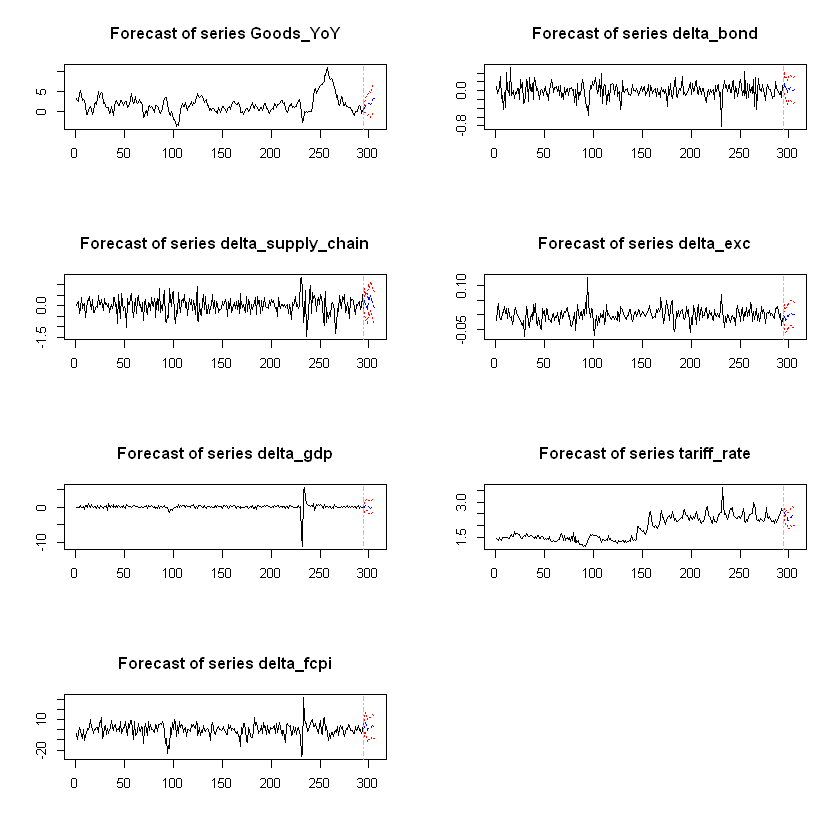

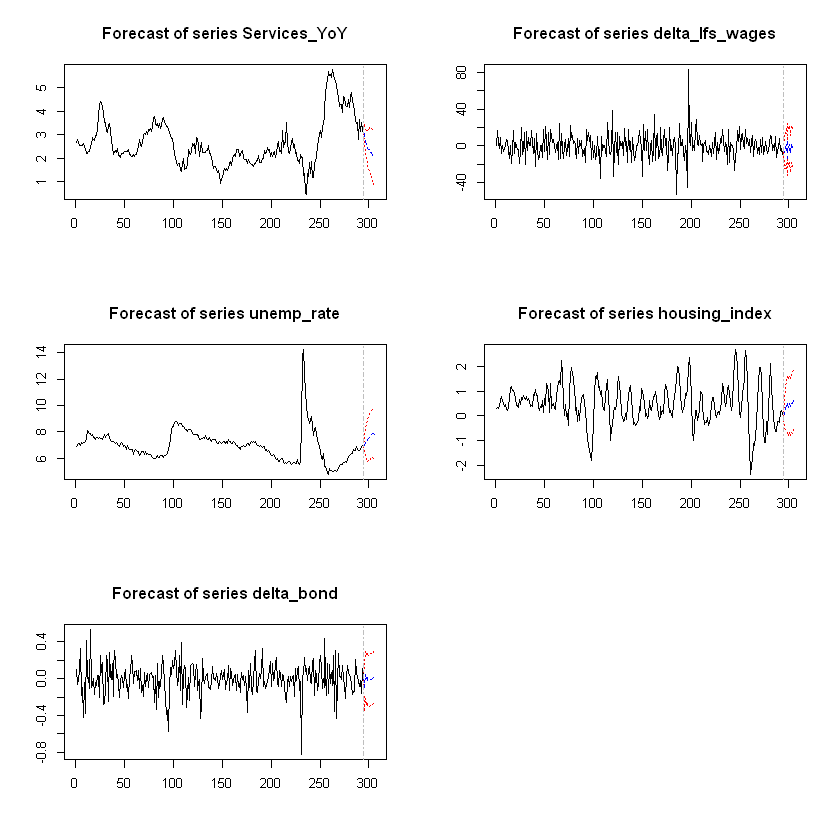

In [17]:

forecast_results_goods <- predict(var_model_goods, n.ahead = 12, ci = 0.90)

plot(forecast_results_goods)

forecast_results_services <- predict(var_model_services, n.ahead = 12, ci = 0.90)

plot(forecast_results_services)

In [18]:
install.packages("ggfortify")

package 'ggfortify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\RtmpGoxMH9\downloaded_packages


In [19]:
library(ggfortify)
library(dplyr)
library(ggplot2)
library(lubridate) # For the years() function

# Convert the forecast object into a tidy dataframe
forecast_df_goods <- fortify(forecast_results_goods)

# Inspect the new dataframe to see its structure
glimpse(forecast_df_goods)
forecast_df_services <- fortify(forecast_results_services)

# Inspect the new dataframe to see its structure
glimpse(forecast_df_services)

Rows: 306
Columns: 36
$ Index                    <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-…
$ Goods_YoY                <dbl> 3.1914894, 2.8511088, 2.4008351, 4.4257113, 5…
$ delta_supply_chain       <dbl> 0.00, 0.15, 0.20, -0.37, -0.13, 0.39, -0.11, …
$ delta_gdp                <dbl> 0.007181486, -0.031518707, 0.058706070, -0.08…
$ delta_fcpi               <dbl> -3.4733370, -9.5590724, -2.4684897, 2.1593704…
$ delta_bond               <dbl> 1.000000e-01, -6.000000e-02, -1.000000e-02, 9…
$ delta_exc                <dbl> -0.0186750000, 0.0183631579, 0.0371777512, -0…
$ tariff_rate              <dbl> 1.451342, 1.418153, 1.369565, 1.512005, 1.436…
$ Goods_YoY.fcst           <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Goods_YoY.lower          <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Goods_YoY.upper          <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Goods_YoY.CI             <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ delta_supply_cha

In [20]:
last_obs_index <- max(which(!is.na(forecast_df_goods$Goods_YoY)))

# Get the value of that last observation
last_obs_value <- forecast_df_goods$Goods_YoY[last_obs_index]

# Copy this last known value to the forecast columns FOR THAT SAME ROW
# This creates the "bridge" that connects the two lines.
forecast_df_goods$Goods_YoY.fcst[last_obs_index] <- last_obs_value
forecast_df_goods$Goods_YoY.lower[last_obs_index] <- last_obs_value
forecast_df_goods$Goods_YoY.upper[last_obs_index] <- last_obs_value


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


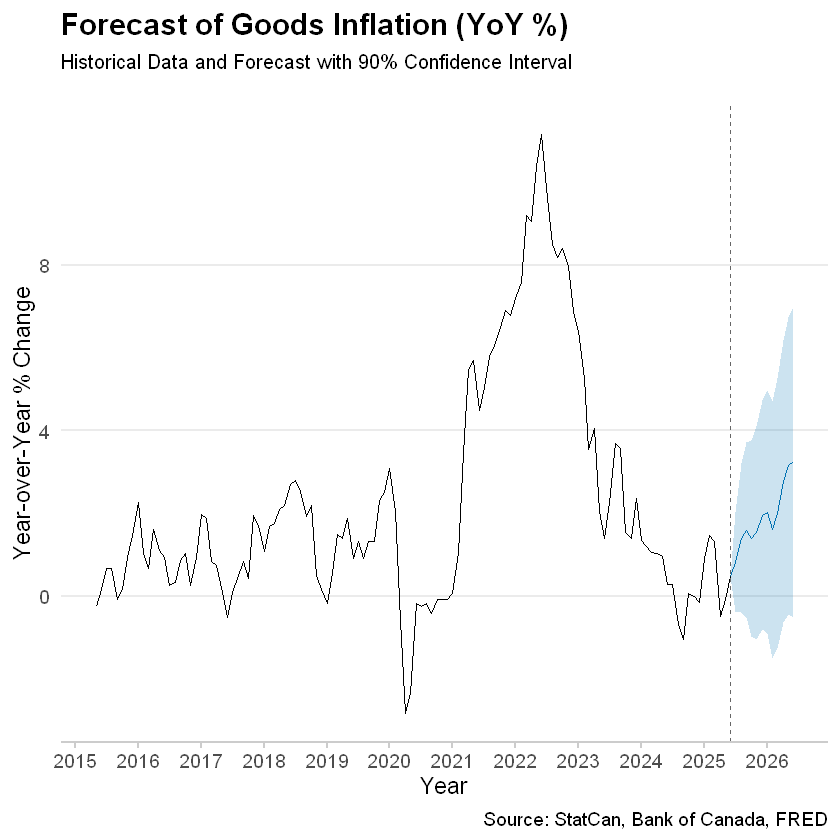

In [21]:
# Find the last date of actual historical data before forecasts begin
last_actual_date <- forecast_df_goods %>%
  filter(!is.na(Goods_YoY) & is.na(Goods_YoY.fcst)) %>%
  summarise(max_date = max(Index)) %>%
  pull(max_date)

# Determine the start date for filtering (5 years before the last actual data point)
start_date <- last_actual_date - years(10)

# Filter the dataframe to include the last 5 years of actual data plus all forecast data
plot_data <- forecast_df_goods %>%
  filter(Index >= start_date)

# Find the date where the forecast officially begins
forecast_start_date <- plot_data %>%
  filter(!is.na(Goods_YoY.fcst)) %>%
  summarise(min_date = min(Index)) %>%
  pull(min_date)

# Create the plot
p <- ggplot(plot_data, aes(x = Index)) +
  # 1. Plot the historical data line (in black)
  geom_line(aes(y = Goods_YoY), color = "black", size = 0.5, na.rm = TRUE) +
  
  # 2. Plot the forecast line (in blue)
  geom_line(aes(y = Goods_YoY.fcst), color = "#0072B2", size = 0.5, na.rm = TRUE) +
  
  # 3. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = Goods_YoY.lower, ymax = Goods_YoY.upper), 
              fill = "#0072B2", 
              alpha = 0.2,    # alpha makes the ribbon transparent
              na.rm = TRUE) +
  
  # 4. Add a vertical dashed line at the start of the forecast period
  geom_vline(xintercept = as.numeric(forecast_start_date), 
             linetype = "dashed", 
             color = "grey40") +
  
  # 5. Apply labels and titles
  labs(
    title = "Forecast of Goods Inflation (YoY %)",
    subtitle = "Historical Data and Forecast with 90% Confidence Interval",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: StatCan, Bank of Canada, FRED"
  ) +
  
  # 6. Customize the x-axis date format
  scale_x_date(
    date_breaks = "1 year", 
    date_labels = "%Y"
  ) +
  
  # 7. Apply a clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80")
  )

print(p)

In [22]:
ggsave(
  "goods_inflation_forecast.png", # The filename for the saved plot
  plot = p,                # The plot object to save
  width = 8,              # Width in inches
  height = 8,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [23]:
last_obs_index <- max(which(!is.na(forecast_df_services$Services_YoY)))

# Get the value of that last observation
last_obs_value <- forecast_df_services$Services_YoY[last_obs_index]

# Copy this last known value to the forecast columns FOR THAT SAME ROW
# This creates the "bridge" that connects the two lines.
forecast_df_services$Services_YoY.fcst[last_obs_index] <- last_obs_value
forecast_df_services$Services_YoY.lower[last_obs_index] <- last_obs_value
forecast_df_services$Services_YoY.upper[last_obs_index] <- last_obs_value

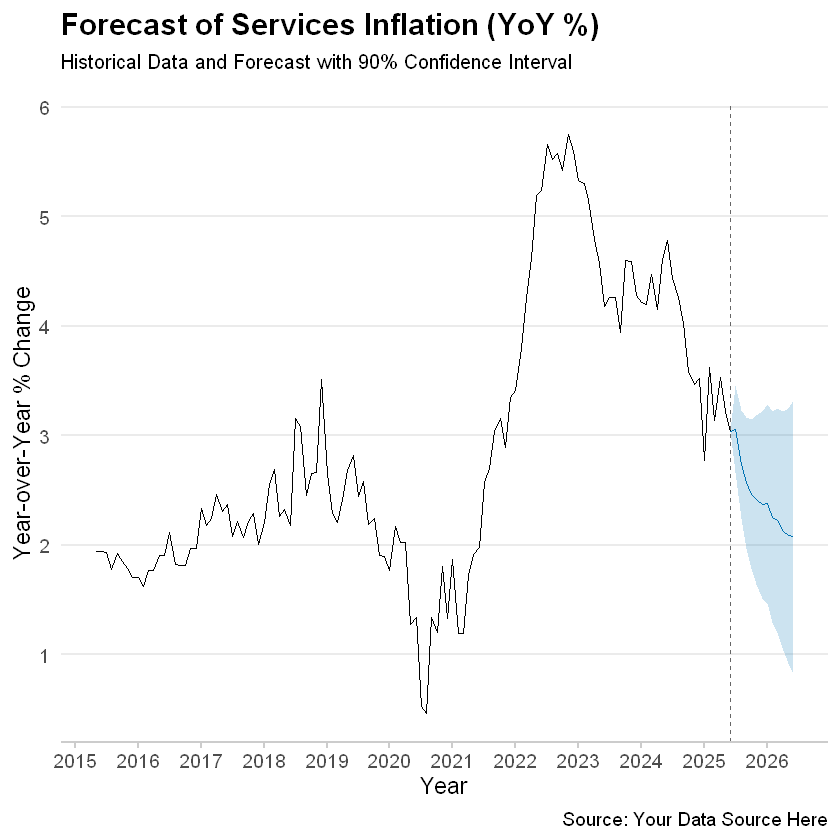

In [24]:
# Find the last date of actual historical data before forecasts begin
last_actual_date <- forecast_df_services %>%
  filter(!is.na(Services_YoY) & is.na(Services_YoY.fcst)) %>%
  summarise(max_date = max(Index)) %>%
  pull(max_date)

# Determine the start date for filtering (5 years before the last actual data point)
start_date <- last_actual_date - years(10)

# Filter the dataframe to include the last 5 years of actual data plus all forecast data
plot_data <- forecast_df_services %>%
  filter(Index >= start_date)

# Find the date where the forecast officially begins
forecast_start_date <- plot_data %>%
  filter(!is.na(Services_YoY.fcst)) %>%
  summarise(min_date = min(Index)) %>%
  pull(min_date)

# Create the plot
ggplot(plot_data, aes(x = Index)) +
  # 1. Plot the historical data line (in black)
  geom_line(aes(y = Services_YoY), color = "black", size = 0.5, na.rm = TRUE) +
  
  # 2. Plot the forecast line (in blue)
  geom_line(aes(y = Services_YoY.fcst), color = "#0072B2", size = 0.5, na.rm = TRUE) +
  
  # 3. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = Services_YoY.lower, ymax = Services_YoY.upper), 
              fill = "#0072B2", 
              alpha = 0.2,    # alpha makes the ribbon transparent
              na.rm = TRUE) +
  
  # 4. Add a vertical dashed line at the start of the forecast period
  geom_vline(xintercept = as.numeric(forecast_start_date), 
             linetype = "dashed", 
             color = "grey40") +
  
  # 5. Apply labels and titles
  labs(
    title = "Forecast of Services Inflation (YoY %)",
    subtitle = "Historical Data and Forecast with 90% Confidence Interval",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: Your Data Source Here"
  ) +
  
  # 6. Customize the x-axis date format
  scale_x_date(
    date_breaks = "1 year", 
    date_labels = "%Y"
  ) +
  
  # 7. Apply a clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80")
  )

In [25]:
ggsave(
  "services_inflation_forecast_2.png", # The filename for the saved plot              # The plot object to save
  width = 8,              # Width in inches
  height = 8,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [26]:
svar_order <- c("delta_exc", "tariff_rate", "delta_trade_unc", "delta_supply_chain", "delta_bond", "delta_fcpi", "delta_gdp", "Goods_YoY")

# 2. Re-order your dataframe and create the time series object
svar_data <- final_monthly_df |>
  dplyr::select(all_of(svar_order)) |>
  ts(start = c(2001, 1), frequency = 12)

# 3. Re-estimate the VAR model with the ordered data
# The Cholesky decomposition is now implicitly defined by your column order
var_model_svar_goods <- VAR(svar_data, p = 12, type = "const")

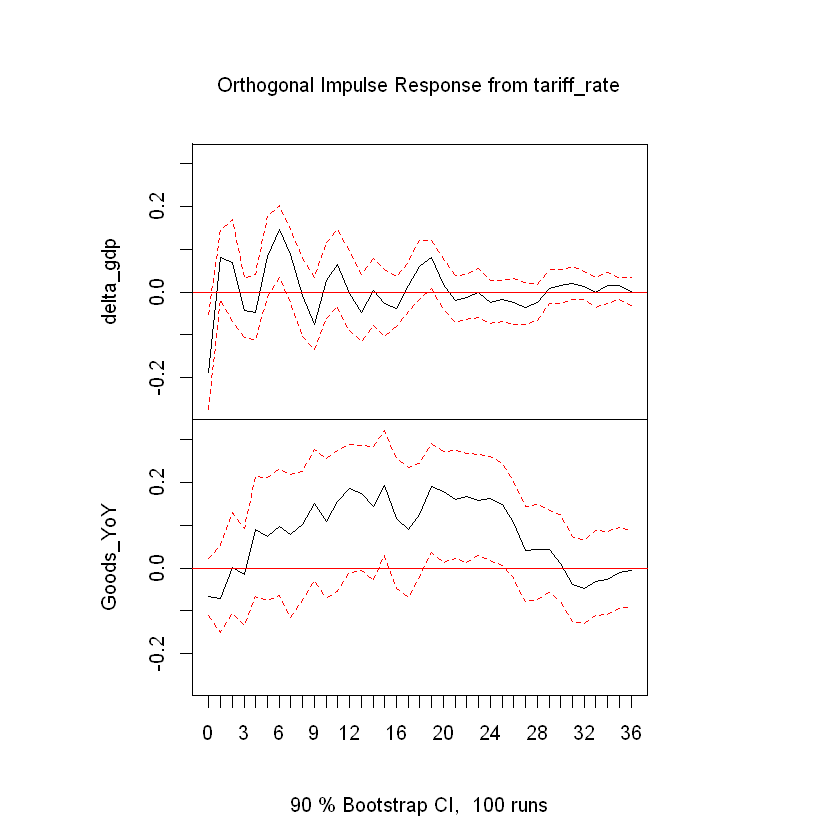

In [27]:
# Generate the IRFs for a shock to the first variable in our order ('delta_trade_unc')
svar_irf <- irf(
  var_model_svar_goods,
  impulse = "tariff_rate",  # The source of the shock
  response = c("Goods_YoY", "delta_gdp"), # The variables that respond
  n.ahead = 36,                 # How many months ahead to forecast
  boot = TRUE,                  # Generate bootstrap confidence intervals
  ci = 0.90                    # 95% confidence interval
)

# Plot the results
plot(svar_irf)

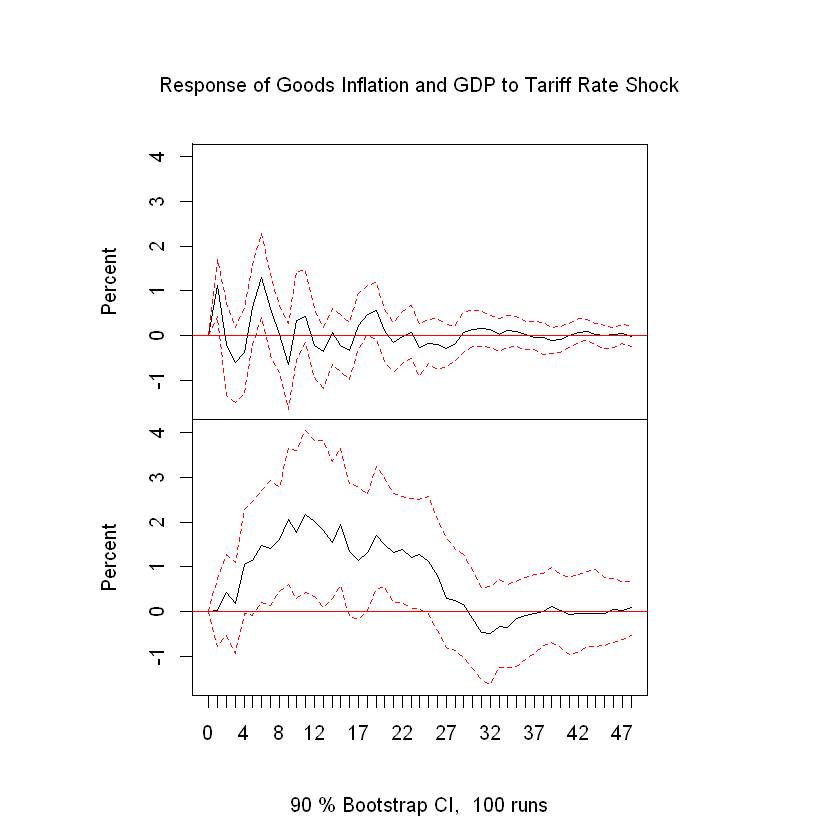

In [28]:
# 1. Your data and estimated VAR model (no changes needed here)
var_model_svar_goods <- vars::VAR(svar_data, p = 12, type = "const")

# 2. Calculate the Generalized Impulse Response Function (GIRF) 💡
# This avoids the ordering assumption of a Cholesky decomposition.
girf_exc_to_goods <- vars::irf(
  var_model_svar_goods,
  impulse = "tariff_rate",
  response = c("Goods_YoY", 'delta_gdp'),
  n.ahead = 48,
  boot = TRUE,
  ortho = FALSE,
  ci = 0.90  # <-- This is the key change
)

# 3. Plot the GIRF
plot(girf_exc_to_goods, main = "Response of Goods Inflation and GDP to Tariff Rate Shock",
     xlab = "Months", ylab = "Percent")

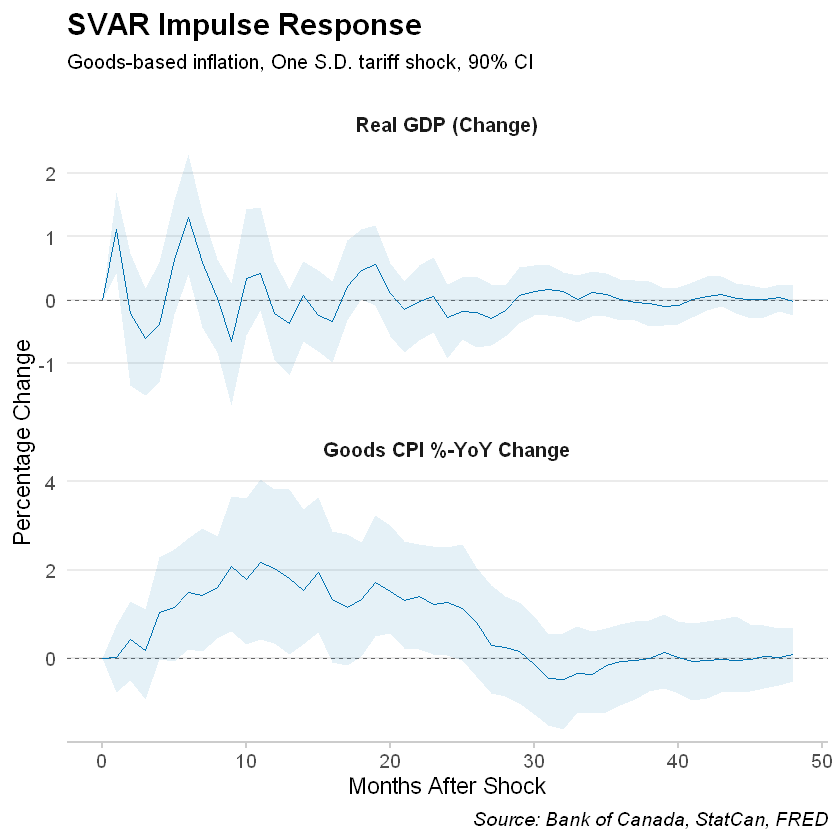

In [56]:
# --- Step 1: Define your custom labels ---
# The names on the left must match the variable names in your data.
# The values on the right are the new labels you want to see on the plot.

response_labels <- c(
  `Goods_YoY` = "Goods CPI %-YoY Change",
  `delta_exc` = "Exchange Rate (Change)",
  `tariff_rate` = "Effective Tariff Rate",
  `delta_trade_unc` = "Trade Uncertainty (Change)",
  `delta_supply_chain` = "Supply Chain Pressure (Change)",
  `delta_bond` = "10-Yr Bond Yield (Change)",
  `delta_fcpi` = "Commodity Prices (Change)",
  `delta_gdp` = "Real GDP (Change)"
)


df_list <- lapply(1:length(girf_exc_to_goods$response), function(i) {
  data.frame(
    period      = 0:(nrow(girf_exc_to_goods$irf$tariff_rate) - 1),
    response    = girf_exc_to_goods$response[i],
    impulse     = girf_exc_to_goods$impulse,
    irf_value   = girf_exc_to_goods$irf$tariff_rate[, i],
    lower_ci    = girf_exc_to_goods$Lower$tariff_rate[, i],
    upper_ci    = girf_exc_to_goods$Upper$tariff_rate[, i]
  )
})

# Combine the list into a single, tidy data frame
plot_df <- do.call(rbind, df_list)

# --- Step 2: Create the plot with the new labeller ---
# The plot object is assigned to a variable 'p'
p <- ggplot(plot_df, aes(x = period)) +

  # 1. Add the zero-line for reference
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey40") +

  # 2. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci),
              fill = "#0072B2",
              alpha = 0.1, 
              na.rm = TRUE) +

  # 3. Plot the main impulse response line
  geom_line(aes(y = irf_value), color = "#0072B2", size = 0.5, na.rm = TRUE) +

  # 4. Create separate plots AND apply the new labels
  facet_wrap(~response, 
             scales = "free_y", 
             ncol = 1,
             labeller = as_labeller(response_labels)) + # <-- This is the key addition

  # 5. Apply labels, title, and subtitle
  labs(
    title = "SVAR Impulse Response",
    subtitle = "Goods-based inflation, One S.D. tariff shock, 90% CI",
    x = "Months After Shock",
    y = "Percentage Change",
    caption = "Source: Bank of Canada, StatCan, FRED"
  ) +

  # 6. Apply a clean theme and customize it
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    plot.caption = element_text(face = "italic"),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color = "grey80"),
    axis.ticks.x = element_line(color = "grey80")
  )

# You can now print the plot to see the result
print(p)

In [57]:
ggsave(
  "irf_plot_goods.png", # The filename for the saved plot
  plot = p,                # The plot object to save
  width = 5,              # Width in inches
  height = 6,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [40]:
svar_order <- c("tariff_rate", "delta_exc", "delta_supply_chain", "delta_bond", "delta_fcpi", "unemp_rate", "Services_YoY", 'delta_lfs_wages', 'housing_index')

# 2. Re-order your dataframe and create the time series object
svar_data_services <- final_monthly_df |>
  dplyr::select(all_of(svar_order)) |>
  ts(start = c(2001, 1), frequency = 12)

# 3. Re-estimate the VAR model with the ordered data
# The Cholesky decomposition is now implicitly defined by your column order
var_model_svar_services <- VAR(svar_data_services, p = 12, type = "const")

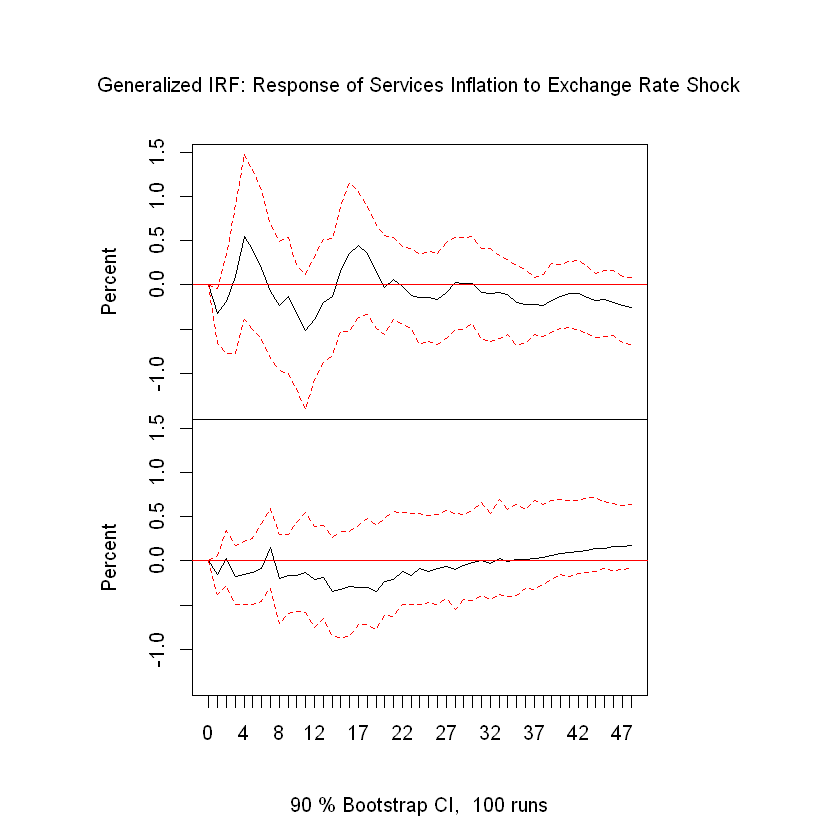

In [50]:
# 1. Your data and estimated VAR model (no changes needed here)
var_model_svar_services <- vars::VAR(svar_data_services, p = 12, type = "const")

# 2. Calculate the Generalized Impulse Response Function (GIRF) 💡
# This avoids the ordering assumption of a Cholesky decomposition.
girf_exc_to_services <- vars::irf(
  var_model_svar_services,
  impulse = "tariff_rate",
  response = c("Services_YoY", "unemp_rate"),
  n.ahead = 48,
  boot = TRUE,
  ortho = FALSE,
  ci = 0.90  # <-- This is the key change
)

# 3. Plot the GIRF
plot(girf_exc_to_services, main = "Generalized IRF: Response of Services Inflation to Exchange Rate Shock",
     xlab = "Months", ylab = "Percent")

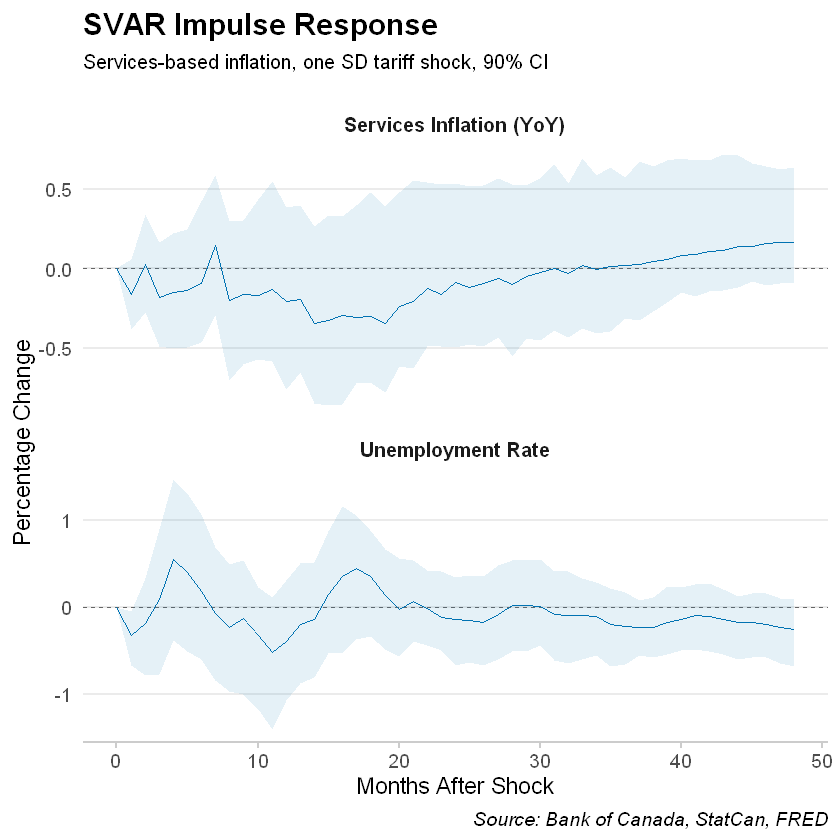

In [51]:
# Make sure ggplot2 is loaded
library(ggplot2)

# --- Step 1: Reshape your 'girf' data for plotting ---
# (This is your original code for creating the data frame)
df_list <- lapply(1:length(girf_exc_to_services$response), function(i) {
  data.frame(
    period      = 0:(nrow(girf_exc_to_services$irf$tariff_rate) - 1),
    response    = girf_exc_to_services$response[i],
    impulse     = girf_exc_to_services$impulse,
    irf_value   = girf_exc_to_services$irf$tariff_rate[, i],
    lower_ci    = girf_exc_to_services$Lower$tariff_rate[, i],
    upper_ci    = girf_exc_to_services$Upper$tariff_rate[, i]
  )
})
plot_df <- do.call(rbind, df_list)


# --- Step 2: Create the lookup list for your new labels ---
# This uses your variable names on the left.
professional_names <- c(
  `Services_YoY` = "Services Inflation (YoY)",
  `unemp_rate`   = "Unemployment Rate"
)


# --- Step 3: Create the final plot ---
# The only change here is adding the 'labeller' argument to facet_wrap.
p <- ggplot(plot_df, aes(x = period)) +

  # 1. Add the zero-line for reference
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey40") +

  # 2. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci),
              fill = "#0072B2",
              alpha = 0.1,
              na.rm = TRUE) +

  # 3. Plot the main impulse response line
  geom_line(aes(y = irf_value), color = "#0072B2", size = 0.5, na.rm = TRUE) +

  # 4. Create separate plots and apply the new professional names
  facet_wrap(~response, scales = "free_y", ncol = 1, labeller = as_labeller(professional_names)) +

  # 5. Apply labels, title, and subtitle
  labs(
    title = "SVAR Impulse Response",
    subtitle = "Services-based inflation, one SD tariff shock, 90% CI",
    x = "Months After Shock",
    y = "Percentage Change",
    caption = "Source: Bank of Canada, StatCan, FRED"
  ) +

  # 6. Apply a clean theme and customize it
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    plot.caption = element_text(face = "italic"),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color = "grey80"),
    axis.ticks.x = element_line(color = "grey80")
  )

# You can now print the plot to see the result
print(p)

In [52]:
ggsave(
  "irf_plot_services.png", # The filename for the saved plot
  plot = p,                # The plot object to save
  width = 5,              # Width in inches
  height = 6,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

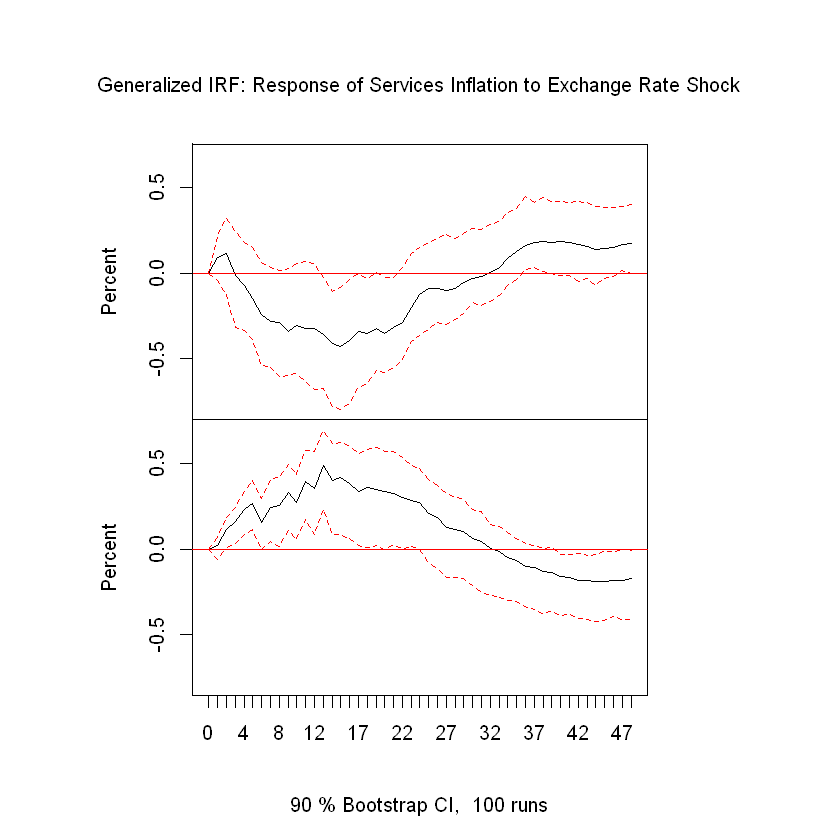

In [53]:
# 1. Your data and estimated VAR model (no changes needed here)
var_model_svar_services_housing <- vars::VAR(svar_data_services, p = 12, type = "const")

# 2. Calculate the Generalized Impulse Response Function (GIRF) 💡
# This avoids the ordering assumption of a Cholesky decomposition.
girf_exc_to_services_housing <- vars::irf(
  var_model_svar_services_housing,
  impulse = "housing_index",
  response = c("Services_YoY", "unemp_rate"),
  n.ahead = 48,
  boot = TRUE,
  ortho = FALSE,
  ci = 0.90  # <-- This is the key change
)

# 3. Plot the GIRF
plot(girf_exc_to_services_housing, main = "Generalized IRF: Response of Services Inflation to Exchange Rate Shock",
     xlab = "Months", ylab = "Percent")

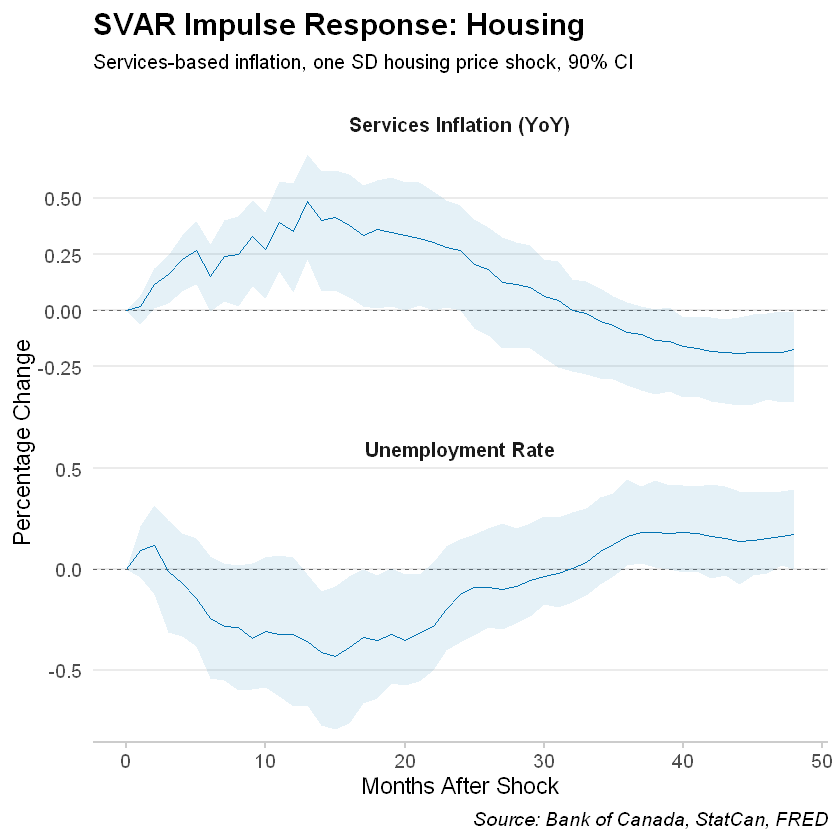

In [54]:
# Make sure ggplot2 is loaded
library(ggplot2)

# --- Step 1: Reshape your 'girf' data for plotting ---
# (This is your original code for creating the data frame)
df_list <- lapply(1:length(girf_exc_to_services_housing$response), function(i) {
  data.frame(
    period      = 0:(nrow(girf_exc_to_services_housing$irf$housing_index) - 1),
    response    = girf_exc_to_services_housing$response[i],
    impulse     = girf_exc_to_services_housing$impulse,
    irf_value   = girf_exc_to_services_housing$irf$housing_index[, i],
    lower_ci    = girf_exc_to_services_housing$Lower$housing_index[, i],
    upper_ci    = girf_exc_to_services_housing$Upper$housing_index[, i]
  )
})
plot_df <- do.call(rbind, df_list)


# --- Step 2: Create the lookup list for your new labels ---
# This uses your new variable names on the left.
professional_names <- c(
  `Services_YoY` = "Services Inflation (YoY)",
  `unemp_rate`   = "Unemployment Rate"
)


# --- Step 3: Create the final plot ---
# The only change here is adding the 'labeller' argument to facet_wrap.
p <- ggplot(plot_df, aes(x = period)) +

  # 1. Add the zero-line for reference
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey40") +

  # 2. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci),
              fill = "#0072B2",
              alpha = 0.1,
              na.rm = TRUE) +

  # 3. Plot the main impulse response line
  geom_line(aes(y = irf_value), color = "#0072B2", size = 0.5, na.rm = TRUE) +

  # 4. Create separate plots and apply the new professional names
  facet_wrap(~response, scales = "free_y", ncol = 1, labeller = as_labeller(professional_names)) +

  # 5. Apply labels, title, and subtitle
  labs(
    title = "SVAR Impulse Response: Housing",
    subtitle = "Services-based inflation, one SD housing price shock, 90% CI",
    x = "Months After Shock",
    y = "Percentage Change",
    caption = "Source: Bank of Canada, StatCan, FRED"
  ) +

  # 6. Apply a clean theme and customize it
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    plot.caption = element_text(face = "italic"),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color = "grey80"),
    axis.ticks.x = element_line(color = "grey80")
  )

# You can now print the plot to see the result
print(p)

In [55]:
ggsave(
  "housing.png", # The filename for the saved plot
  plot = p,                # The plot object to save
  width = 10,              # Width in inches
  height = 6,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [35]:
goods_cpi_data <- forecast_df_goods |>
  dplyr::select(
    date = Index,
    goods_actual = Goods_YoY,
    goods_predicted = Goods_YoY.fcst,
    goods_lower = Goods_YoY.lower,
    goods_upper = Goods_YoY.upper
  )

services_cpi_data <- forecast_df_services |>
  dplyr::select(
    date = Index,
    services_actual = Services_YoY,
    services_predicted = Services_YoY.fcst,
    services_lower = Services_YoY.lower,
    services_upper = Services_YoY.upper
  )

In [36]:
# Join the two data frames by date
reconstructed_cpi_df <- full_join(goods_cpi_data, services_cpi_data, by = "date")

# Calculate the weighted sums for both actual and predicted values,
# including the confidence intervals.
reconstructed_cpi_df <- reconstructed_cpi_df |>
  mutate(
    # Reconstruct the actual overall CPI
    cpi_actual = 44.45/100 * goods_actual + 55.55/100 * services_actual,
    
    # Reconstruct the predicted overall CPI
    cpi_predicted = 44.45/100 * goods_predicted + 55.55/100 * services_predicted,
    
    # Reconstruct the lower and upper bounds of the confidence interval
    cpi_lower = 44.45/100 * goods_lower + 55.55/100 * services_lower,
    cpi_upper = 44.45/100 * goods_upper + 55.55/100 * services_upper
  )

In [37]:
print(tail(reconstructed_cpi_df))

          date goods_actual goods_predicted goods_lower goods_upper
301 2026-01-01           NA        2.037476  -0.8891849    4.964137
302 2026-02-01           NA        1.613700  -1.4911749    4.718575
303 2026-03-01           NA        1.998589  -1.2577747    5.254952
304 2026-04-01           NA        2.771382  -0.6349247    6.177689
305 2026-05-01           NA        3.155439  -0.4302293    6.741108
306 2026-06-01           NA        3.251284  -0.5135912    7.016160
    services_actual services_predicted services_lower services_upper cpi_actual
301              NA           2.377992      1.4718095       3.284175         NA
302              NA           2.254980      1.2913843       3.218575         NA
303              NA           2.230240      1.2077742       3.252706         NA
304              NA           2.129616      1.0357779       3.223454         NA
305              NA           2.086708      0.9224304       3.250985         NA
306              NA           2.077162      

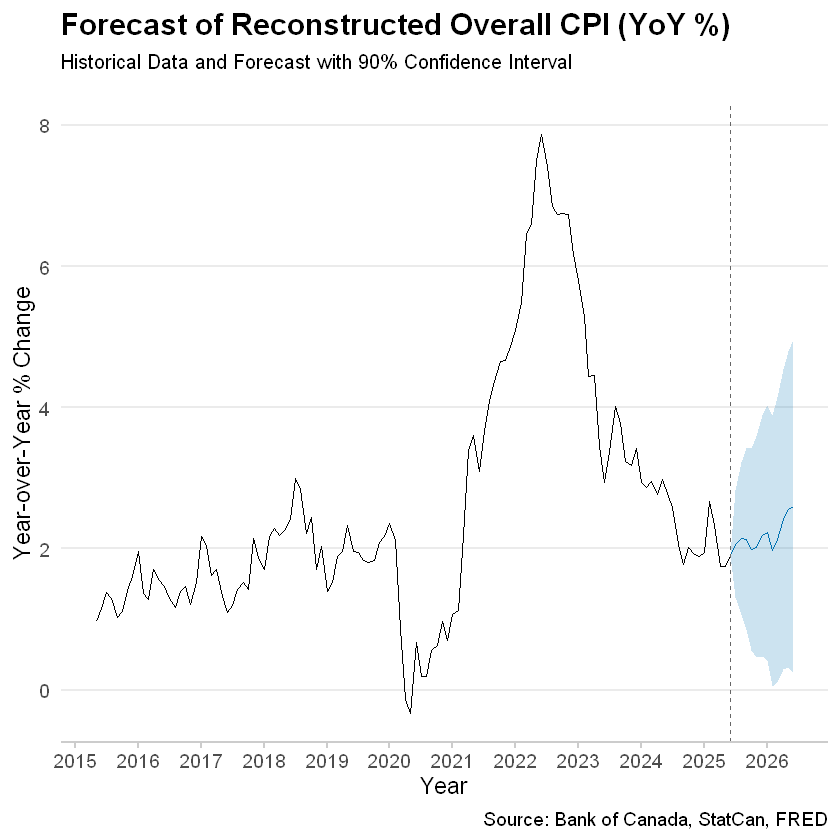

In [38]:

# Find the last date of actual historical data before forecasts begin
last_actual_date <- reconstructed_cpi_df |>
  filter(!is.na(cpi_actual) & is.na(cpi_predicted)) |>
  summarise(max_date = max(date)) |>
  pull(max_date)

# Determine the start date for filtering (10 years before the last actual data point)
start_date <- last_actual_date - years(10)

# Filter the dataframe to include the last 10 years of actual data plus all forecast data
plot_data <- reconstructed_cpi_df |>
  filter(date >= start_date)

# Find the date where the forecast officially begins
forecast_start_date <- plot_data |>
  filter(!is.na(cpi_predicted)) |>
  summarise(min_date = min(date)) |>
  pull(min_date)

# Create the plot
p <- ggplot(plot_data, aes(x = date)) +
  # 1. Plot the historical data line (in black)
  geom_line(aes(y = cpi_actual), color = "black", size = 0.5, na.rm = TRUE) +
  
  # 2. Plot the forecast line (in blue)
  geom_line(aes(y = cpi_predicted), color = "#0072B2", size = 0.5, na.rm = TRUE) +
  
  # 3. Add the shaded confidence interval ribbon
  geom_ribbon(aes(ymin = cpi_lower, ymax = cpi_upper),
              fill = "#0072B2",
              alpha = 0.2, # alpha makes the ribbon transparent
              na.rm = TRUE) +
  
  # 4. Add a vertical dashed line at the start of the forecast period
  geom_vline(xintercept = as.numeric(forecast_start_date),
             linetype = "dashed",
             color = "grey40") +
  
  # 5. Apply labels and titles
  labs(
    title = "Forecast of Reconstructed Overall CPI (YoY %)",
    subtitle = "Historical Data and Forecast with 90% Confidence Interval",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: Bank of Canada, StatCan, FRED"
  ) +
  
  # 6. Customize the x-axis date format
  scale_x_date(
    date_breaks = "1 year",
    date_labels = "%Y"
  ) +
  
  # 7. Apply a clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color = "grey80"),
    axis.ticks.x = element_line(color = "grey80")
  )

print(p)

In [39]:
ggsave(
  "cpi_reconstructed_forecast.png", # The filename for the saved plot
  plot = p,                # The plot object to save
  width = 15,              # Width in inches
  height = 7,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)